# Compute foraging behavior
### a) Validate with proteomics
### b) Inverse: estimate environment probabilities from foraging proteomics/transcriptome

### Forward
$$
\begin{align}
\max_{v^k,e}  \quad & f^T e + \sum_k p^k (c^T v^k) \\
\mathrm{s.t.} \quad & S^k v^k = 0 \\
                    & \sum_j e_j \leq P \\
                    & \sum_j e^k_j \leq P^k \\
                    & e^k_j = e_j + \delta_j^k \\
                    & v^k_j \leq k^\mathrm{eff}_j \cdot e_j \\
                    & l^k \leq v^k \leq u^k \\
                    & e \geq 0
\end{align}
$$

## With expression deviation constraints/objective

## Regulatory constraints
1. Parsimonious regulator 

1. Function of flux
$$
\begin{align}
& p_j = \sum_i \alpha_{ij} v_j
\end{align}
$$

In [127]:
from __future__ import division

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [2]:
from dynamicme.optimize import StackOptimizer

In [3]:
mdl0 = load_json_model('/home/laurence/ME/models/e_coli_core_mm.json')
crowd0 = mdl0.metabolites.crowding

## Environment probabilities

In [4]:
# Uniform
import json
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/cnps_conds.json') as f:
    cnps = json.load(f)
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/media_exchanges.json') as f:
    cnps_rxns = json.load(f)

In [5]:
conds = cnps['C']

In [6]:
rows = []
for csrc in conds:
    ex_rxn = cnps_rxns[csrc]
    if mdl0.reactions.has_id(ex_rxn):
        # Reset all other ex rxns to zero
        for csrcj in cnps['C']:
            ex_rxnj = cnps_rxns[csrcj]
            if mdl0.reactions.has_id(ex_rxnj):
                rows.append({'cond':csrc, 'rxn':ex_rxnj, 'lb':0., 'ub':1000., 'obj':0.})
        if csrc=='Acetate':
            lb = -20.
        else:
            lb = -10.
        if mdl0.reactions.has_id(ex_rxn):
            rows.append({'cond':csrc, 'rxn':ex_rxn, 'lb':lb, 'ub':1000., 'obj':0.})

In [7]:
df_conds = pd.DataFrame(rows)
df_X = df_conds
conds = df_X.cond.unique()

## Drop infeasible conds

In [8]:
stat_dict = {}
for cond in conds:
    dfi = df_conds[ df_conds.cond==cond]
    for i,row in dfi.iterrows():
        rid = row['rxn']
        rxn = mdl0.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    mdl0.optimize()
    stat_dict[cond] = mdl0.solution.status

In [9]:
for ind,stat in iteritems(stat_dict):
    if stat != 'optimal':
        df_X = df_X[ df_X.cond != ind]
conds = df_X.cond.unique()

In [10]:
len(df_X.cond.unique())

13

In [11]:
from dynamicme.decomposition.LagrangeSubmodel import LagrangeSubmodel
from dynamicme.decomposition.LagrangeMaster import LagrangeMaster
from dynamicme.optimize import StackOptimizer

## Full-space model

In [12]:
stacker = StackOptimizer()
stacker.stack_models(mdl0, df_X)

In [13]:
from dynamicme.optimize import clone_attributes
from dynamicme.optimize import Variable, Constraint

es0 = mdl0.reactions.query('^e_')
es  = []
for e0j in es0:
    ej = Variable(e0j.id)
    clone_attributes(e0j, ej)
    es.append(ej)

stacker.model.add_reactions(es)

crowd0 = mdl0.metabolites.crowding
P_cap = crowd0._bound

dps = []
for ej in es:
    ### Add sum_j mwj*ej <= P
    cons = Constraint('crowding')
    cons._constraint_sense = 'L'
    cons._bound = P_cap
    e0 = mdl0.reactions.get_by_id(ej.id)
    mwj = e0.metabolites[crowd0]
    ej.add_metabolites({cons:mwj})
    for ind,mdli in iteritems(stacker.model_dict):            
        ejk = stacker.model.reactions.get_by_id("%s_%s"%(ej.id, ind))        
        ### Add some flexibility to respond within each condition
        # ejk = ej0 + dejk
        # ejk - ej0 - dejk = 0
        dejk = Variable('de_%s_%s'%(ej.id,ind), lower_bound=-1000, upper_bound=1000)
        stacker.model.add_reaction(dejk)
        cons = Constraint('prot_response_%s_%s'%(ej.id, ind))
        cons._constraint_sense = 'E'
        cons._bound = 0
        stacker.model.add_metabolites(cons)
        dejk.add_metabolites({cons:-1.})
        ej.add_metabolites({cons:-1.})
        ejk.add_metabolites({cons:1.})

In [14]:
stacker.model.optimize(solver='gurobi')

<Solution 6.11 at 0x7f53c3881710>

## Sample across proteome response capacities

In [15]:
N_SAMPLES = 100
DPs = np.linspace(0, 0.1, N_SAMPLES)
#DPs = [0]
mu_id = 'BIOMASS_Ecoli_core_w_GAM'
rows = []

for DP in DPs:
    for ind,mdli in iteritems(stacker.model_dict):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
            
    stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9)
    
    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for ind in stacker.model_dict.keys():
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows.append(
                    {'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows.append({'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

In [16]:
# from cobra.solvers import gurobi_solver
# solver = gurobi_solver.create_problem(stacker.model)
# solver.Params.FeasibilityTol = 1e-9
# solver.Params.OptimalityTol = 1e-9
# solver.optimize()
# sol = gurobi_solver.format_solution(solver, stacker.model)
# stacker.model.solution = sol

In [17]:
df_result = pd.DataFrame(rows)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [21]:
df_result.shape

(59800, 9)

In [22]:
df_result.head(2)

,cond,dek,dp_max,e0,ek,mu_tot,muk,protein,stat
0,Fumarate,-0.0,0.0,0.000679,0.000679,3.60841,0.366792,e_ACALD,optimal
1,L-Glutamate,-0.0,0.0,0.000679,0.000679,3.60841,0.598450,e_ACALD,optimal


In [23]:
table = df_result.pivot_table(index=['cond','dp_max'], columns='protein', values='ek')

In [24]:
from sklearn import preprocessing

In [25]:
Z_AXIS = 1   # Z-score'd proteome for each cond
pca = PCA()
X = table.values
Z = preprocessing.scale(X, axis=Z_AXIS)

Z_new = pca.fit_transform(Z)

Z_new.shape

dp_maxs = [ix[1] for ix in table.index]

dsplot = pd.DataFrame.from_dict({'PC1':Z_new[:,0], 'PC2':Z_new[:,1], 'dp_max':dp_maxs})

Z.shape

sns.set_style('darkgrid')

labels = set(dp_maxs)
n_labels = len(labels)
cmap_id = 'GnBu'
cmap = sns.color_palette(cmap_id, n_labels)

#g = sns.FacetGrid(dsplot, size=5, hue='dp_max', palette=cmap)
#g.map(plt.scatter, 'PC1','PC2', cmap=cmap)
# for ax in g.axes.flat:
#     pass
sns.set_palette(cmap)
pts = plt.scatter(dsplot.PC1, dsplot.PC2, c=dsplot.dp_max, cmap=cmap_id, edgecolor='#000000',
                  lw=0.3, s=49, alpha=0.8)
#sns.despine(offset=1, trim=True)

plt.colorbar(pts)
pts.axes.set_aspect('equal')
pts.axes.figure.set_size_inches(7,6)

In [31]:
df_result.head(2)

,cond,dek,dp_max,e0,ek,mu_tot,muk,protein,stat
0,Fumarate,-0.0,0.0,0.000679,0.000679,3.60841,0.366792,e_ACALD,optimal
1,L-Glutamate,-0.0,0.0,0.000679,0.000679,3.60841,0.598450,e_ACALD,optimal


In [41]:
df_mu_tot = df_result[['dp_max','mu_tot']].drop_duplicates()

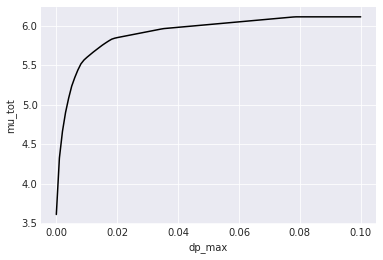

In [42]:
pts = plt.plot('dp_max','mu_tot', data=df_mu_tot, color='#000000')
ax = pts[0].axes
ax.set_xlabel('dp_max')
ax.set_ylabel('mu_tot')

In [43]:
df_growth = df_result[['cond','dp_max','mu_tot','muk']].drop_duplicates()
df_growth.head(2)

,cond,dp_max,mu_tot,muk
0,Fumarate,0.0,3.60841,0.366792
1,L-Glutamate,0.0,3.60841,0.598450


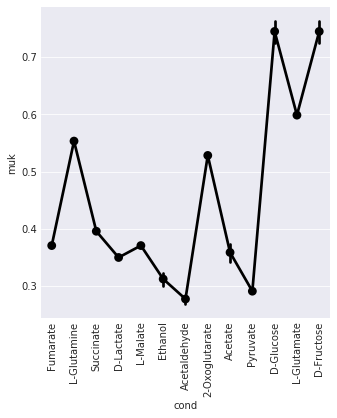

In [44]:
fg = sns.factorplot('cond', 'muk', data=df_growth.sort_values('mu_tot'), color='#000000', size=5)
fg.set_xticklabels(rotation=90)

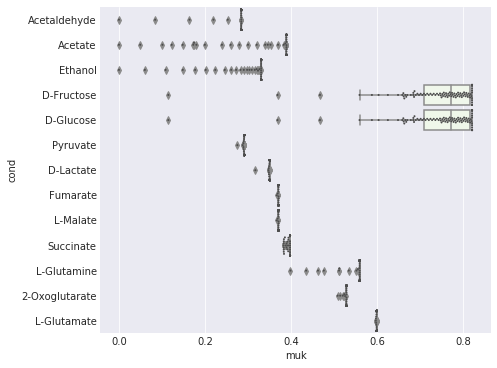

In [45]:
f,ax = plt.subplots(figsize=(7,6))
df_growthi = df_growth.sort_values('muk')
sns.boxplot(x='muk', y='cond', data=df_growthi)
sns.swarmplot(x='muk',y='cond', data=df_growthi, size=2, color='.3', linewidth=0)
#ax.xaxis.grid(True)

# Validate mus where measured

In [69]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')
ex_rxns = [r for r in df_meas.ex_rxn.unique() if mdl0.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]

In [72]:
df_meas.head()

,substrate,growth_rate_1_h,order,ex_rxn
0,glucose,0.740,0.0,EX_glc__D_e
3,fructose,0.550,NaN,EX_fru_e
5,succinate,0.460,NaN,EX_succ_e
6,malate,0.440,NaN,EX_mal__L_e
9,acetate,0.256,5.0,EX_ac_e


In [98]:
df_growth.loc[:,'substrate'] = df_growth.cond.apply(lambda x: x.lower().replace('l-','').replace('d-',''))

df_val = pd.merge(df_meas, df_growth, on='substrate')

In [100]:
df_val.cond.unique()

array([u'D-Glucose', u'D-Fructose', u'Succinate', u'L-Malate', u'Acetate'],
      dtype=object)

In [101]:
df_val.loc[:,'Measured'] = df_val.growth_rate_1_h
df_val.loc[:,'Simulated'] = df_val.muk
df_val.head()

,substrate,growth_rate_1_h,order,ex_rxn,cond,dp_max,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00000,3.608410,0.114731,0.74,0.114731
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00101,4.323613,0.368450,0.74,0.368450
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00202,4.662177,0.467057,0.74,0.467057
3,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00303,4.900699,0.558999,0.74,0.558999
4,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00404,5.080627,0.587808,0.74,0.587808


In [102]:
df_val.substrate.unique()

array(['glucose', 'fructose', 'succinate', 'malate', 'acetate'],
      dtype=object)

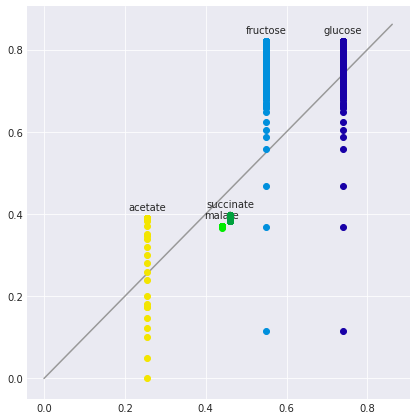

In [113]:
colors = sns.color_palette('nipy_spectral')
g = sns.FacetGrid(size=6, data=df_val)
mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
plt.plot([0,mumax], [0,mumax], color='.6')
#pts = plt.scatter('Measured','Simulated', data=df_val, zorder=4, c='#000000')
for k,subs in enumerate(df_val.substrate.unique()):
    dfi = df_val[ df_val.substrate==subs]
    color = colors[k]
    plt.scatter('Measured','Simulated', data=dfi, zorder=4, c=color)
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')

In [116]:
df_val.head(3)

,substrate,growth_rate_1_h,order,ex_rxn,cond,dp_max,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00000,3.608410,0.114731,0.74,0.114731
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00101,4.323613,0.368450,0.74,0.368450
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.00202,4.662177,0.467057,0.74,0.467057


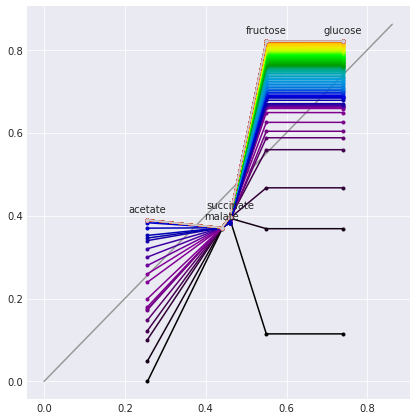

In [165]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

#colors = sns.color_palette('nipy_spectral')
cols = cmx.get_cmap('nipy_spectral')
cnorm = colors.Normalize(vmin=0, vmax=dp_maxs[-1])
cmap = cmx.ScalarMappable(norm=cnorm, cmap=cols)

g = sns.FacetGrid(size=6, data=df_val)
mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
plt.plot([0,mumax], [0,mumax], color='.6')

dp_maxs = df_val.dp_max.unique()
for k,dp in enumerate(dp_maxs):
    dfi = df_val[ df_val.dp_max==dp]
    #plt.scatter()
    cval = cmap.to_rgba(dp)
    pts = plt.plot('Measured','Simulated', data=dfi, color=cval, marker='.', alpha=1)

for k,subs in enumerate(df_val.substrate.unique()):
    dfi = df_val[ df_val.substrate==subs]    
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')

# Sample probabilities for fixed dp_max

In [196]:
n_conds = len(conds)

N_SAMPLES = 100
#DPs = np.linspace(0, 0.1, N_SAMPLES)
#DPs = [0]
mu_id = 'BIOMASS_Ecoli_core_w_GAM'
rows = []

#DP = 0.05
DP = 0.01

for kk in range(N_SAMPLES):
    ps = np.random.uniform(size=n_conds)
    ps = ps / sum(ps)
    for k,(ind,mdli) in enumerate(iteritems(stacker.model_dict)):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
        rxn_mu = stacker.model.reactions.get_by_id('%s_%s'%(mu_id,ind))
        rxn_mu.objective_coefficient = ps[k]
            
    stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9)
    
    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for k,ind in enumerate(stacker.model_dict.keys()):
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows.append(
                    {'dp_max':DP, 'prob':ps[k], 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows.append({'dp_max':DP, 'prob':np.nan, 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

In [197]:
df_prob = pd.DataFrame(rows)

In [198]:
table = df_prob.pivot_table(index=['cond','sample'], columns='protein', values='ek')

In [199]:
table.shape

(1300, 46)

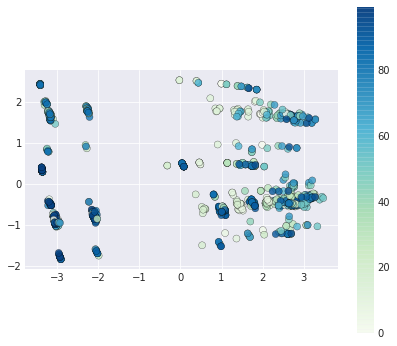

In [200]:
Z_AXIS = 1   # Z-score'd proteome for each cond
pca = PCA()
X = table.values
Z = preprocessing.scale(X, axis=Z_AXIS)

Z_new = pca.fit_transform(Z)
probs = [ix[1] for ix in table.index]
dsplot = pd.DataFrame.from_dict({'PC1':Z_new[:,0], 'PC2':Z_new[:,1], 'sample':probs})

sns.set_style('darkgrid')

labels = set(probs)
n_labels = len(labels)
cmap_id = 'GnBu'
cmap = sns.color_palette(cmap_id, n_labels)

sns.set_palette(cmap)
pts = plt.scatter(dsplot.PC1, dsplot.PC2, c=dsplot['sample'], cmap=cmap_id, edgecolor='#000000',
                  lw=0.3, s=49, alpha=0.8)

plt.colorbar(pts)
pts.axes.set_aspect('equal')
pts.axes.figure.set_size_inches(7,6)

In [201]:
df_growth2 = df_prob[['cond','sample','mu_tot','muk']].drop_duplicates()
df_growth2.loc[:,'substrate'] = df_growth2.cond.apply(lambda x: x.lower().replace('l-','').replace('d-',''))
df_val2 = pd.merge(df_meas, df_growth2, on='substrate')
df_val2.loc[:,'Measured'] = df_val2.growth_rate_1_h
df_val2.loc[:,'Simulated'] = df_val2.muk
df_val2.head()

,substrate,growth_rate_1_h,order,ex_rxn,cond,sample,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0,0.494821,0.807369,0.74,0.807369
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,1,0.447075,0.698019,0.74,0.698019
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,2,0.432425,0.733720,0.74,0.733720
3,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,3,0.469007,0.756117,0.74,0.756117
4,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,4,0.464107,0.671773,0.74,0.671773


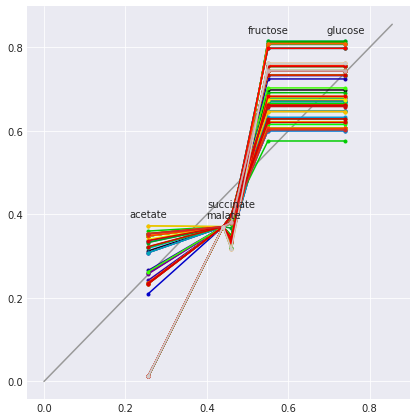

In [202]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

samples = df_val2['sample'].unique()
cols = cmx.get_cmap('nipy_spectral')
cnorm = colors.Normalize(vmin=0, vmax=samples[-1])
cmap = cmx.ScalarMappable(norm=cnorm, cmap=cols)

g = sns.FacetGrid(size=6, data=df_val2)
mumax = max(df_val2.Measured.max(), df_val2.Simulated.max())*1.05
plt.plot([0,mumax], [0,mumax], color='.6')

for k,sample in enumerate(samples):
    dfi = df_val2[ df_val2['sample']==sample]
    cval = cmap.to_rgba(sample)
    pts = plt.plot('Measured','Simulated', data=dfi, color=cval, marker='.', alpha=1)

for k,subs in enumerate(df_val2.substrate.unique()):
    dfi = df_val2[ df_val2.substrate==subs]    
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')